In [1]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Data Preprocessing
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

import os
import numpy as np
from scipy.signal import resample

def load_data(folder_path):
    data_dict = {}
    labels = None

    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.npy'):
            file_path = os.path.join(folder_path, file)
            data = np.load(file_path)

            if 'label' in file.lower():
                labels = data.squeeze()
            elif data.ndim == 3:
                sensor_name = file.replace('.npy', '')
                data_dict[sensor_name] = data

    return data_dict, labels

def normalize_data(data_dict):
    normalized_data = {}
    for sensor, data in data_dict.items():
        mean = data.mean(axis=(0, 1), keepdims=True)
        std = data.std(axis=(0, 1), keepdims=True) + 1e-8
        normalized_data[sensor] = (data - mean) / std
    return normalized_data

In [2]:
!pip install tsfresh

In [3]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Feature-Extraction
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from tsfresh.feature_extraction.feature_calculators import mean_abs_change, cid_ce

def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum()

def extract_features_from_sample(sample):
    """
    sample: ndarray with shape (T, C)
    Returns: feature vector (flattened over all channels)
    """

    T, C = sample.shape
    features = []

    for c in range(C):
        sig = sample[:, c]

        iqr = np.percentile(sig, 75) - np.percentile(sig, 25)
        pos_peaks, _ = find_peaks(sig)
        neg_peaks, _ = find_peaks(-sig)
        num_pos_peaks = len(pos_peaks)
        num_neg_peaks = len(neg_peaks)
        mac = mean_abs_change(sig)
        cid = cid_ce(sig, normalize=True)


        features.extend([
            np.max(sig),               # Maximum
            np.min(sig),               # Minimum
            np.mean(sig),              # Average
            np.std(sig),               # Standard-deviation
            zero_crossing_rate(sig),   # Zero Crossing Rate
            np.percentile(sig, 20),    # Percentil 20
            np.percentile(sig, 50),    # Median (Percentil 50)
            np.percentile(sig, 80),    # Percentil 80
            iqr,                       # Interquartile(IQR)
            np.var(sig),               # Variance
            num_pos_peaks,             # Number positive Peaks
            num_neg_peaks,             # Number negative Peaks
            mac,                       # Mean Absolute Change
            cid                        # Complexity invariant distance
        ])
    return np.array(features)

def extract_features_from_sample_combined(sample_dict):
    """
    sample_dict: dict of sensor_name -> ndarray (T, C)
    Returns: combined feature vector (flattened over all channels and sensors)
    """
    features = []

    for sensor_name, sample in sample_dict.items():
        feats = extract_features_from_sample(sample)  # Extract features for each sensor sample
        features.extend(feats)  # Combine features from all sensors into a single vector

    return np.array(features)

def extract_features(data_dict):
    """
    data_dict: dict of sensor_name -> ndarray (N, T, C)
    Returns: X -> ndarray (N, F) - Features
    """
    feature_list = []
    n_samples = None

    for sensor_name, sensor_data in data_dict.items():
        if n_samples is None:
            n_samples = sensor_data.shape[0]
        elif n_samples != sensor_data.shape[0]:
            raise ValueError(f"Inkonsistente Anzahl an Samples im Sensor '{sensor_name}'")

    # Extract features for each sample by combining all sensors
    for i in range(n_samples):
        sample_dict = {sensor_name: data[i] for sensor_name, data in data_dict.items()}
        feats = extract_features_from_sample_combined(sample_dict)
        feature_list.append(feats)

    # Stack all features
    X = np.vstack(feature_list)
    return X

In [4]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Feature-Selection: RFE with Cross-Validation
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

def run_feature_selection_rfecv(X, y, cv_folds=5, scoring='f1_macro'):
    print("[INFO] Skaliere Features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print("[INFO] Führe RFECV durch...")
    estimator = RandomForestClassifier(n_estimators=100, random_state=42)
    cv = StratifiedKFold(n_splits=cv_folds)

    selector = RFECV(estimator, step=1, cv=cv, scoring=scoring, n_jobs=-1)
    selector.fit(X_scaled, y)

    X_selected = selector.transform(X_scaled)
    selected_indices = np.where(selector.support_)[0]

    print("[INFO] RFECV abgeschlossen.")
    print(f"Optimal number of features: {selector.n_features_}")
    print("Top Feature Indices:", selected_indices)

    return X_selected, scaler, selector

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
DO NOT RUN!
Main: Load Data, extract Features, save Feature-Selection Parameters, train Classifier
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

from google.colab import drive
drive.mount('/content/drive')

# === Set the path to the training and test folders ===
training_folder = "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/training"
testing_folder = "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/testing"

# === Load Trainings- und Testdata ===
training_data_dict, training_labels = load_data(training_folder)
testing_data_dict, testing_labels = load_data(testing_folder)

# === Normalize Trainings- und Testdata ===
normalized_training_data = normalize_data(training_data_dict)
normalized_testing_data = normalize_data(testing_data_dict)

# === Feature-Extraktion ===
X_train = extract_features(normalized_training_data)
X_test = extract_features(normalized_testing_data)

# === Feature-Selection ===
X_train_selected, scaler, selector = run_feature_selection_rfecv(X_train, training_labels)

# === Save Scaler & Selector ===
joblib.dump(scaler, "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/models/scaler_RDF.pkl")
joblib.dump(selector, "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/models/rfecv_selector_RDF.pkl")

# === Transform Testdata ===
X_test_scaled = scaler.transform(X_test)
X_test_selected = selector.transform(X_test_scaled)

# === Split Training / Validation ===
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_selected, training_labels, test_size=0.2, random_state=42)

# === Classification ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# === Train model on Trainingsdata ===
clf.fit(X_train_split, y_train_split)

# === Validation ===
y_val_pred = clf.predict(X_val_split)

# === Test ===
y_test_pred = clf.predict(X_test_selected)

# === Output when executing this cell ===

# [INFO] Skaliere Features...
# [INFO] Führe RFECV durch...
# [INFO] RFECV abgeschlossen.
# Optimal number of features: 97
# Top Feature Indices: [  1   2   7  14  15  16  17  19  20  21  22  23  30  33  37  42  54  57
#   58  65  68  75  82  86  89  91  92 106 110 140 142 143 149 152 156 180
#  182 183 184 185 187 188 189 191 194 196 197 198 201 202 203 218 246 252
#  253 254 257 258 259 264 267 268 269 271 272 273 275 278 281 282 285 287
#  292 297 303 306 320 325 334 336 337 338 341 342 343 350 351 352 355 356
#  357 364 365 366 369 370 371]

Mounted at /content/drive
[INFO] Skaliere Features...
[INFO] Führe RFECV durch...
[INFO] RFECV abgeschlossen.
Optimal number of features: 97
Top Feature Indices: [  1   2   7  14  15  16  17  19  20  21  22  23  30  33  37  42  54  57
  58  65  68  75  82  86  89  91  92 106 110 140 142 143 149 152 156 180
 182 183 184 185 187 188 189 191 194 196 197 198 201 202 203 218 246 252
 253 254 257 258 259 264 267 268 269 271 272 273 275 278 281 282 285 287
 292 297 303 306 320 325 334 336 337 338 341 342 343 350 351 352 355 356
 357 364 365 366 369 370 371]


In [5]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
SUPERVISOR ADJUSTMENT NEEDED; SEE COMMENTS
Main: Load Data, extract Features, use Feature-Selection Parameters, train Classifier
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

from google.colab import drive
drive.mount('/content/drive')

# === Set the path to the training and test folders; PLEASE ADJUST it to run the code locally on your machine. ===
training_folder = "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/training"
testing_folder = "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/testing"

# === Load Trainings- und Testdata ===
training_data_dict, training_labels = load_data(training_folder)
testing_data_dict, testing_labels = load_data(testing_folder)

# === Normalize Trainings- und Testdata ===
normalized_training_data = normalize_data(training_data_dict)
normalized_testing_data = normalize_data(testing_data_dict)

# === Feature-Extraktion ===
X_train = extract_features(normalized_training_data)
X_test = extract_features(normalized_testing_data)

# === Load Scaler & Selector; PLEASE ADJUST it to run the code locally on your machine. ===
scaler = joblib.load("/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/models/scaler_RDF.pkl")
selector = joblib.load("/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/models/rfecv_selector_RDF.pkl")

# === Transform Trainingdata with loaded Scaler and Selector ===
X_train_scaled = scaler.transform(X_train)
X_train_selected = selector.transform(X_train_scaled)

# === Transform Testdata ===
X_test_scaled = scaler.transform(X_test)
X_test_selected = selector.transform(X_test_scaled)

# === Split Training / Validation ===
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_selected, training_labels, test_size=0.2, random_state=42)

# === Classification ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_split, y_train_split)

# === Validation ===
y_val_pred = clf.predict(X_val_split)

# === Test ===
y_test_pred = clf.predict(X_test_selected)

Mounted at /content/drive


Validation Accuracy: 0.8030634573304157
Test Accuracy: 0.6346153846153846
Average F1-Score (Macro) on validationdata: 0.7912539491248236
Average F1-Score (Macro) on testdata: 0.6302502218006897
F1-Score for each class (Testset):
 [0.95121951 0.79338843 0.5        0.63888889 0.51851852 0.65909091
 0.41558442 0.27777778 0.10909091 0.42857143 0.62068966 0.67692308
 0.95       0.6741573  0.81395349 0.94252874 0.74226804 0.91566265
 0.53846154 0.60273973 0.51851852 0.35294118 0.5        0.36781609
 0.         0.53125    0.57831325 0.28571429 0.6744186  0.63013699
 0.72527473 0.65168539 0.78873239 0.70588235 0.48484848 0.63768116
 0.82191781 0.59459459 0.75       0.875      0.87128713 0.81578947
 0.73469388 0.73170732 0.93975904 0.46280992 0.55696203 0.49180328
 0.63414634 0.68686869 0.75       0.76190476 0.36111111 0.88095238
 0.73972603]


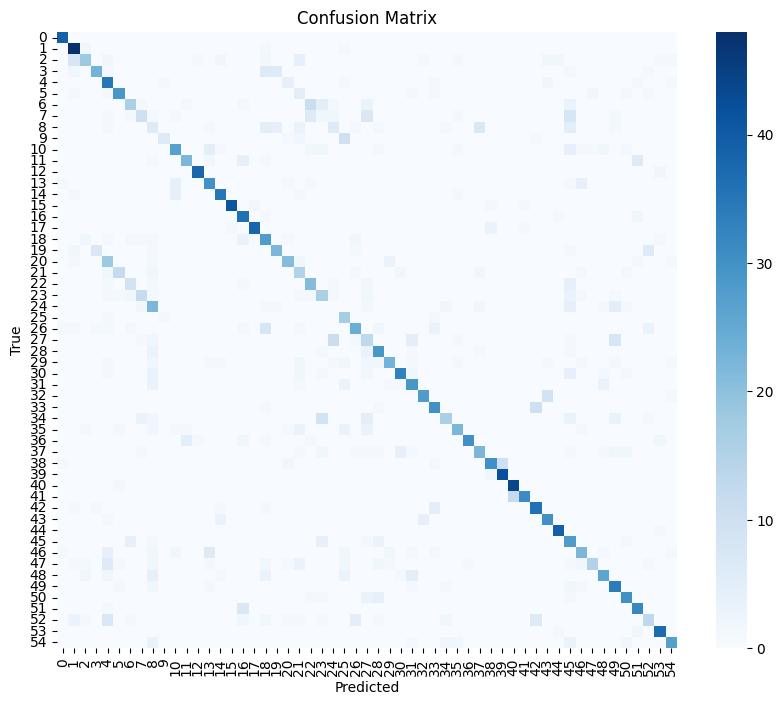

In [6]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Evaluation
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

from sklearn.metrics import classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# === Accuracies ===
print("Validation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print("Test Accuracy:", accuracy_score(testing_labels, y_test_pred))

# === Average F1 Score (Macro) ===
f1_macro_val = f1_score(y_val_split, y_val_pred, average='macro')
print("Average F1-Score (Macro) on validationdata:", f1_macro_val)
f1_macro_test = f1_score(testing_labels, y_test_pred, average='macro')
print("Average F1-Score (Macro) on testdata:", f1_macro_test)

# === F1 Score for each class ===
print("F1-Score for each class (Testset):\n", f1_score(testing_labels, y_test_pred, average=None))

# === Confusion Matrix ===
cm = confusion_matrix(testing_labels, y_test_pred)

# === Set classes (0 to 54) ===
class_names = [str(i) for i in range(55)]

# === Heatmap Confusion Matrix ===
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=True)

# === Axis labels and title ===
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()